# Common


In [ ]:
!pip install ultralytics
!pip install opencv-python
!pip install -q supervision
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Python/signs.zip -d /content

Archive:  drive/MyDrive/Python/signs.zip
   creating: /content/signs/
  inflating: /content/__MACOSX/._signs  
   creating: /content/signs/valid/
  inflating: /content/__MACOSX/signs/._valid  
  inflating: /content/signs/.DS_Store  
  inflating: /content/__MACOSX/signs/._.DS_Store  
   creating: /content/signs/test/
  inflating: /content/__MACOSX/signs/._test  
  inflating: /content/signs/data.yaml  
  inflating: /content/__MACOSX/signs/._data.yaml  
   creating: /content/signs/train/
  inflating: /content/__MACOSX/signs/._train  
   creating: /content/signs/valid/images/
  inflating: /content/__MACOSX/signs/valid/._images  
   creating: /content/signs/valid/labels/
  inflating: /content/__MACOSX/signs/valid/._labels  
   creating: /content/signs/test/images/
  inflating: /content/__MACOSX/signs/test/._images  
   creating: /content/signs/test/labels/
  inflating: /content/__MACOSX/signs/test/._labels  
  inflating: /content/signs/train/.DS_Store  
  inflating: /content/__MACOSX/signs/

In [ ]:
import os
import shutil
import locale
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import tensorflow as tf

from PIL import Image
from ultralytics import YOLO
from keras.preprocessing import image
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from os import listdir, sep
from os.path import abspath, basename, isdir
from keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
def process_folder(source_dir, dest_dir):
    shutil.copytree(source_dir, dest_dir)
    for split in ["train", "valid", "test"]:
        for filename in os.listdir(os.path.join(dest_dir, split, "labels")):
            if filename.endswith(".txt"):
                labelpath = os.path.join(dest_dir, split, "labels", filename)
                with open(labelpath, "r") as f:
                    lines = f.readlines()

                with open(labelpath, "w") as f:
                    for line in lines:
                        modified_line = "0" + line[1:]
                        f.write(modified_line)

source_dir = os.path.join("/content/signs")
dest_dir = os.path.join("/content/signs_one_class")
process_folder(source_dir, dest_dir)

print("Файлы успешно изменены и перемещены.")

Файлы успешно изменены и перемещены.


In [ ]:
classes = ["crosswalk", "speedlimit", "stop", "trafficlight"]

def process_folder(source_dir, dest_dir):
    for c in classes:
        os.makedirs(os.path.join(dest_dir, "images", c), exist_ok=True)
        os.makedirs(os.path.join(dest_dir, "labels", c), exist_ok=True)

    for filename in os.listdir(os.path.join(source_dir, "labels")):
        if filename.endswith(".txt"):
            labelpath = os.path.join(source_dir, "labels", filename)
            with open(labelpath, "r") as f:
                lines = f.readlines()

            num_objects = len(lines)

            if num_objects == 1:
                imagepath = os.path.join(source_dir, "images", filename[:-4] + ".jpg")
                class_name = classes[int(lines[0].split(" ")[0])]

                target_image = '{0}/images/{1}/{2}'.format(dest_dir, class_name, filename[:-4] + ".jpg")
                target_labes = '{0}/labels/{1}/{2}'.format(dest_dir, class_name, filename)

                shutil.copy(imagepath, target_image)
                shutil.copy(labelpath, target_labes)

for split in ["train", "valid", "test"]:
    source_dir = os.path.join("/content/signs", split)
    dest_dir = os.path.join("/content/signs_vgg16", split)

    process_folder(source_dir, dest_dir)

print("Файлы успешно разделены и перемещены.")

Файлы успешно разделены и перемещены.


In [ ]:
def crop_and_save_images(source_dirs, dest_dir):
    for source_dir in source_dirs:
        dataset_type = os.path.basename(source_dir)

        for c in classes:
            label_dir = os.path.join(source_dir, "labels", c)
            image_dir = os.path.join(source_dir, "images", c)
            cropped_image_class_dir = os.path.join(dest_dir, dataset_type, c)  # Save to dataset_type/c/
            os.makedirs(cropped_image_class_dir, exist_ok=True)

            for label_file in os.listdir(label_dir):
                if label_file.endswith(".txt"):
                    image_file = label_file[:-4] + ".jpg"
                    image_path = os.path.join(image_dir, image_file)
                    label_path = os.path.join(label_dir, label_file)

                    with open(label_path, "r") as f:
                        data = f.readline().split(" ")
                        class_name = classes[int(data[0])]
                        x1, y1, width, height = map(float, data[1:])

                    with Image.open(image_path) as img:
                        img_width, img_height = img.size
                        left = int((x1 - (width / 2)) * img_width)
                        top = int((y1 - (height / 2)) * img_height)
                        right = int((x1 + (width / 2)) * img_width)
                        bottom = int((y1 + (height / 2)) * img_height)

                        cropped_img = img.crop((left, top, right, bottom))
                        cropped_img.save(os.path.join(cropped_image_class_dir, image_file))

source_dirs = ["/content/signs_vgg16/train", "/content/signs_vgg16/valid", "/content/signs_vgg16/test"]
dest_dir = "/content/cropped_images"
crop_and_save_images(source_dirs, dest_dir)
print("Обрезанные изображения успешно сохранены в новую папку.")

Обрезанные изображения успешно сохранены в новую папку.


In [ ]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

# YOLOv8

100%|██████████| 6.23M/6.23M [00:00<00:00, 229MB/s]



image 1/1 /content/drive/MyDrive/Python/sign_test.jpg: 640x448 5 cars, 144.1ms
Speed: 14.0ms preprocess, 144.1ms inference, 1033.1ms postprocess per image at shape (1, 3, 640, 448)


array([[[119, 101,  94],
        [118, 100,  93],
        [151, 133, 126],
        ...,
        [227, 203, 205],
        [214, 192, 194],
        [230, 208, 210]],

       [[127, 114, 106],
        [170, 157, 149],
        [174, 161, 153],
        ...,
        [223, 202, 204],
        [214, 193, 195],
        [235, 214, 216]],

       [[185, 183, 173],
        [211, 206, 197],
        [167, 160, 151],
        ...,
        [213, 201, 201],
        [207, 193, 194],
        [231, 217, 218]],

       ...,

       [[121,  99,  81],
        [120,  98,  80],
        [111,  89,  71],
        ...,
        [ 98,  80, 109],
        [ 99,  81, 110],
        [100,  82, 111]],

       [[115,  95,  78],
        [120, 100,  83],
        [111,  91,  74],
        ...,
        [ 96,  76, 105],
        [ 98,  79, 106],
        [ 98,  79, 106]],

       [[114,  94,  77],
        [120, 100,  83],
        [112,  92,  75],
        ...,
        [ 93,  73, 102],
        [ 95,  76, 103],
        [ 95,  76, 103]]], dtype=uint8)
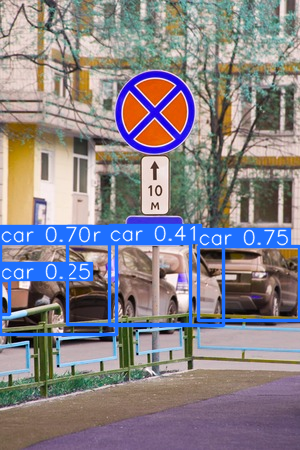

In [ ]:
model = YOLO('yolov8n.pt')

results = model('drive/MyDrive/Python/sign_test.jpg')
results[0].plot()

In [ ]:
history_yolov8 = model.train(data = "/content/signs/data.yaml", epochs = 5)

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/signs/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 75.1MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 225 layers, 3011628 parameters, 3011612 gradients, 8.2 GFLOPs

Transferred 58/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/signs/train/labels... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<00:00, 1964.04it/s]

train: New cache created: /content/signs/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/signs/valid/labels... 174 images, 0 backgrounds, 0 corrupt: 100%|██████████| 174/174 [00:00<00:00, 1117.92it/s]

val: New cache created: /content/signs/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.51G      1.849      3.706      1.661         10        640: 100%|██████████| 39/39 [00:17<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

                   all        174        247      0.941     0.0246      0.158      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.39G      1.185      2.219      1.168          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        174        247      0.432      0.362      0.404      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.39G      1.078      1.846      1.091          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        174        247      0.624      0.535      0.577      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.38G     0.9891      1.591      1.072          7        640: 100%|██████████| 39/39 [00:12<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

                   all        174        247      0.743      0.633      0.675      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.38G     0.9504       1.45      1.046          7        640: 100%|██████████| 39/39 [00:12<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

                   all        174        247      0.792      0.738      0.779      0.589



5 epochs completed in 0.026 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


                   all        174        247      0.792      0.738      0.779       0.59
             crosswalk        174         36      0.696        0.7      0.772      0.583
            speedlimit        174        165      0.949      0.976      0.986      0.796
                  stop        174         18      0.746      0.778        0.8      0.664
          trafficlight        174         28      0.777      0.499      0.559      0.314
Speed: 0.2ms preprocess, 3.7ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
!mv runs/detect/train runs/detect/train_yolov8

In [ ]:
model_best_yolov8 = YOLO("runs/detect/train_yolov8/weights/best.pt")

In [ ]:
def plot_images(x , n):
    path = glob.glob(x)
    res = model_best_yolov8.predict(path[n:n+n])
    for i in range(n):
        detect = res[i]
        img = Image.fromarray(detect.plot())
        plt.figure(dpi=100)
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout()
        plt.show()


0: 640x640 1 stop, 5.0ms
1: 640x640 1 stop, 5.0ms
2: 640x640 2 speedlimits, 5.0ms
3: 640x640 1 speedlimit, 5.0ms
4: 640x640 1 crosswalk, 1 speedlimit, 5.0ms
5: 640x640 1 speedlimit, 5.0ms
6: 640x640 1 speedlimit, 5.0ms
7: 640x640 1 speedlimit, 5.0ms
8: 640x640 1 speedlimit, 5.0ms
9: 640x640 1 speedlimit, 5.0ms
Speed: 2.1ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


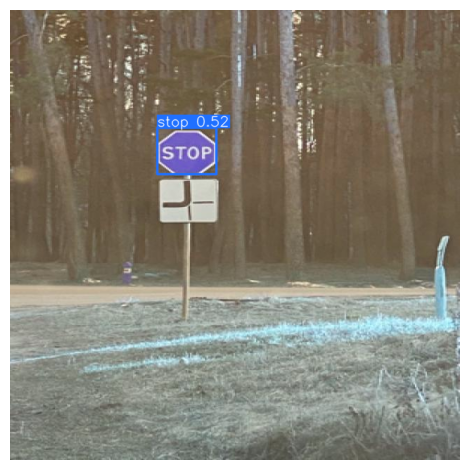

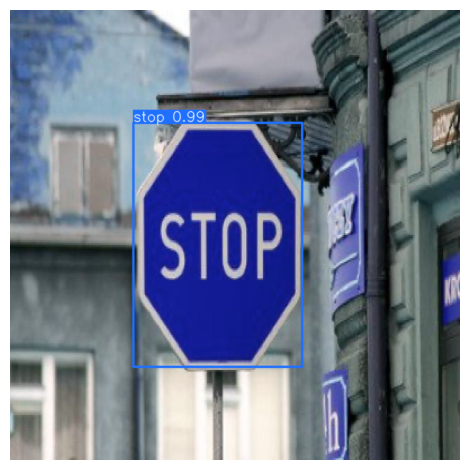

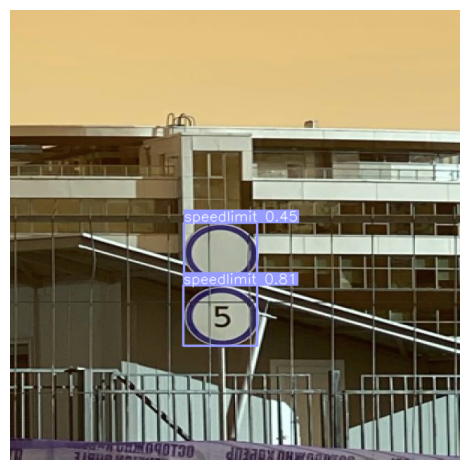

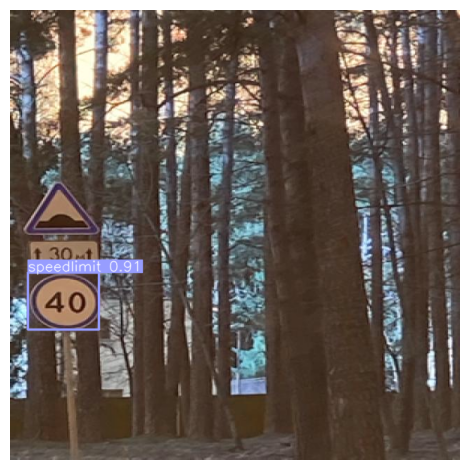

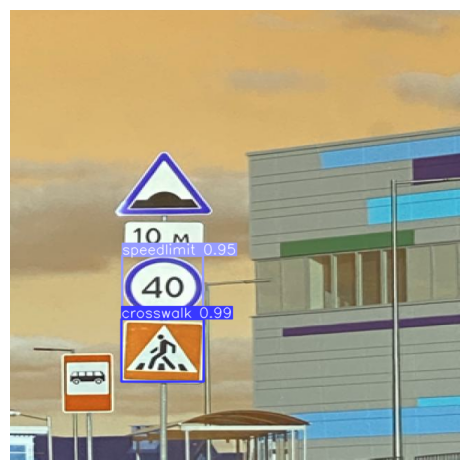

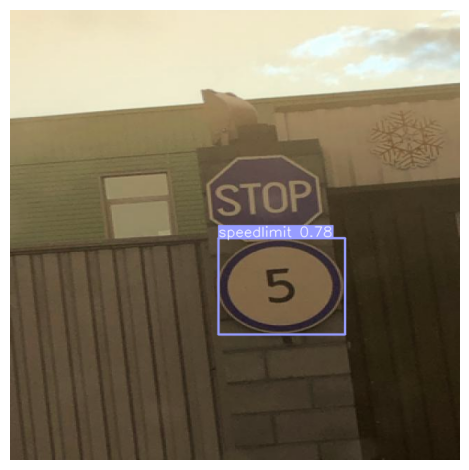

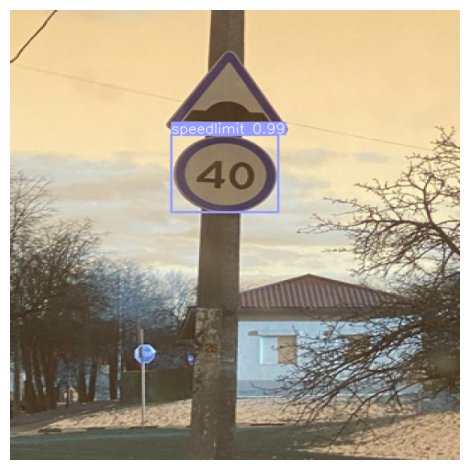

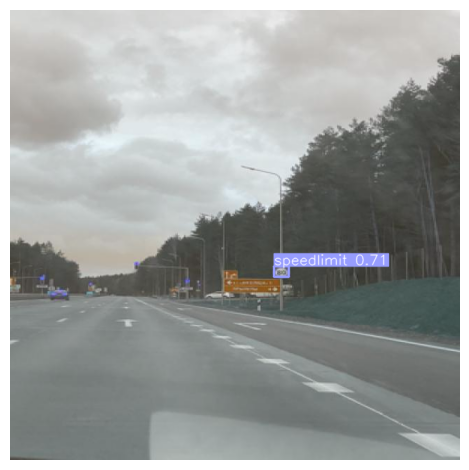

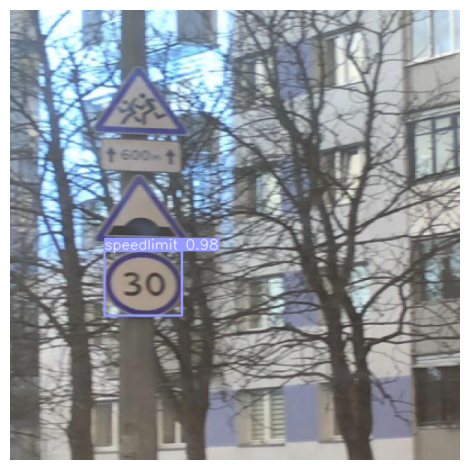

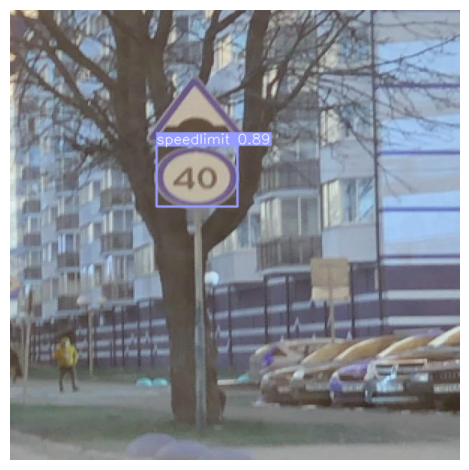

In [ ]:
plot_images("signs/test/images/*", 5)

# Detect


In [ ]:
model = YOLO('yolov8n.pt')

In [ ]:
detect_history = model.train(data = "/content/signs_one_class/data.yaml", epochs = 5)

Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/signs_one_class/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

train: Scanning /content/signs_one_class/train/labels... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<00:00, 1952.08it/s]

train: New cache created: /content/signs_one_class/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/signs_one_class/valid/labels... 174 images, 0 backgrounds, 0 corrupt: 100%|██████████| 174/174 [00:00<00:00, 794.23it/s]

val: New cache created: /content/signs_one_class/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.82G      1.045      2.148      1.057         10        640: 100%|██████████| 39/39 [00:16<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


                   all        174        247      0.917      0.271      0.453      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.57G      1.047      1.488      1.071          7        640: 100%|██████████| 39/39 [00:12<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        174        247      0.404      0.308      0.345      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.58G      1.041      1.403      1.074          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


                   all        174        247      0.462      0.279       0.33      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.56G     0.9556      1.208      1.052          7        640: 100%|██████████| 39/39 [00:12<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


                   all        174        247      0.926      0.817      0.891      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.56G     0.9397      1.095      1.028          7        640: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all        174        247      0.857      0.866      0.899       0.69



5 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


                   all        174        247      0.858      0.866      0.899      0.691
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
!mv runs/detect/train runs/detect/train_detect

In [ ]:
detect_model = YOLO("runs/detect/train_detect/weights/best.pt")

In [ ]:
def plot_images(x , n):
    path = glob.glob(x)
    res = detect_model.predict(path[n:n+n])
    for i in range(n):
        detect = res[i]
        img = Image.fromarray(detect.plot())
        plt.figure(dpi=100)
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout()
        plt.show()


0: 640x640 1 sign, 5.0ms
1: 640x640 3 signs, 5.0ms
2: 640x640 2 signs, 5.0ms
3: 640x640 1 sign, 5.0ms
4: 640x640 3 signs, 5.0ms
5: 640x640 2 signs, 5.0ms
6: 640x640 1 sign, 5.0ms
7: 640x640 1 sign, 5.0ms
8: 640x640 1 sign, 5.0ms
9: 640x640 2 signs, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


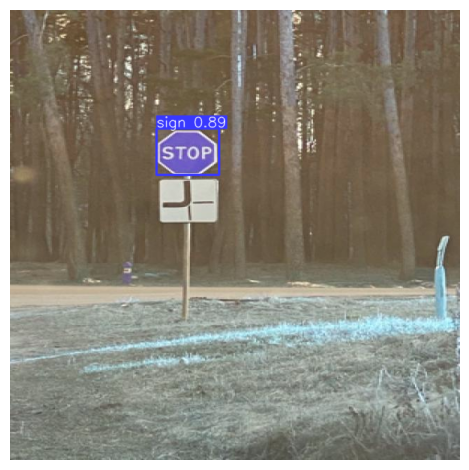

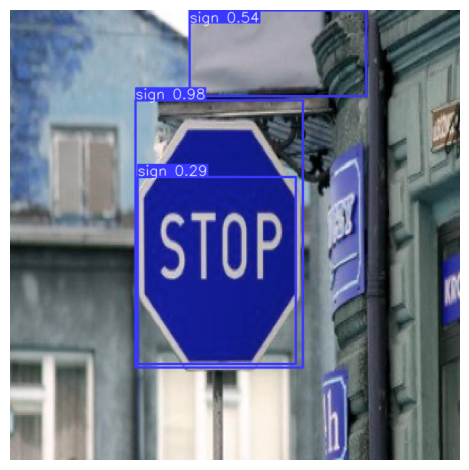

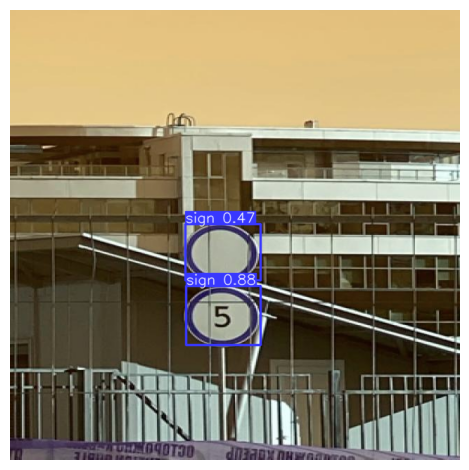

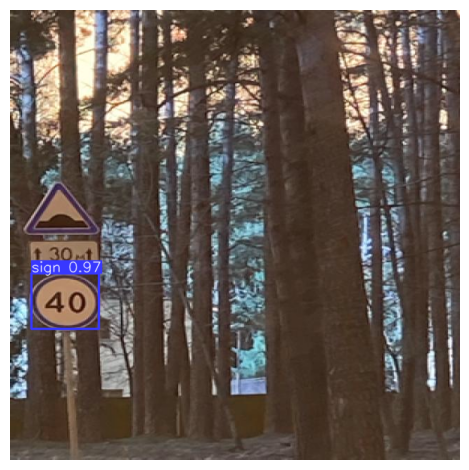

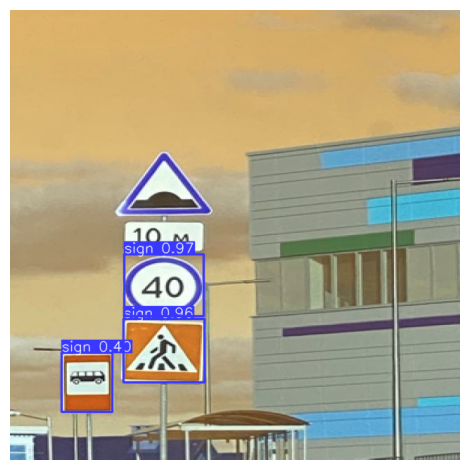

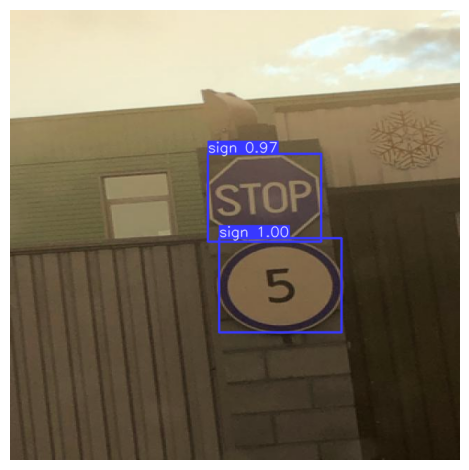

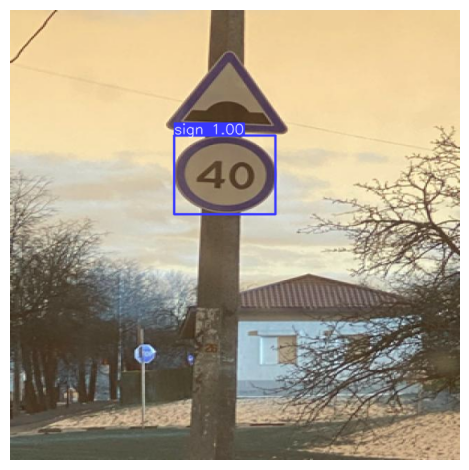

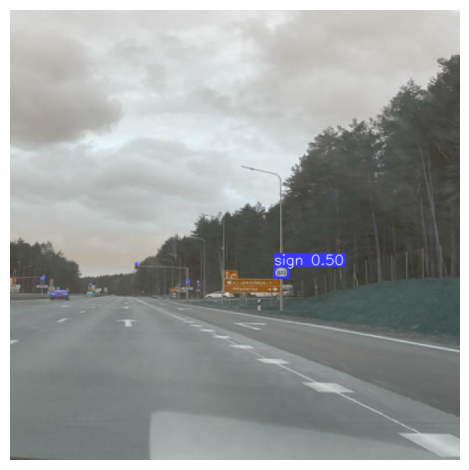

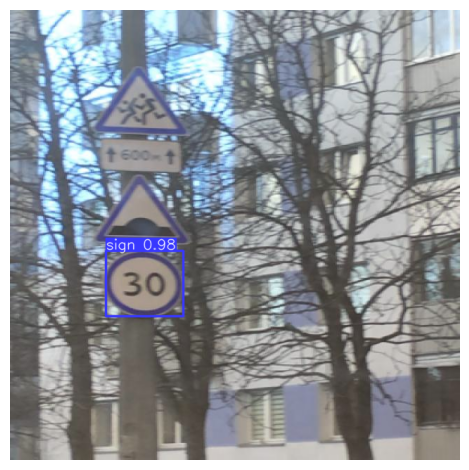

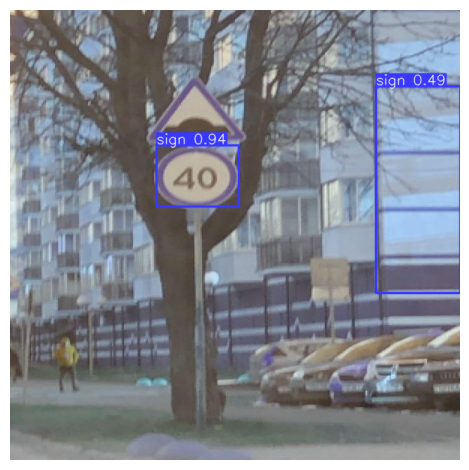

In [ ]:
plot_images("signs/test/images/*", 10)

# VGG 16


In [ ]:
def tree(dir, padding= '  ', print_files=False):
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print(padding*level + pieces[-1] + symbol)

In [ ]:
train_dir = 'cropped_images/train'
val_dir = 'cropped_images/valid'
test_dir = 'cropped_images/test'

img_width, img_height = 150, 150

input_shape = (img_width, img_height, 3)

nb_train_samples = 613
nb_validation_samples = 174
nb_test_samples = 88

num_classes = 4
batch_size = 32
epochs = 30

In [ ]:
classes = {
  0: 'crosswalk',
  1: 'speedlimit',
  2: 'stop',
  3: 'trafficlight'
}

train_dir = os.path.join(train_dir)

test_dir = os.path.join(test_dir)

|  train/
|  |  stop/
|  |  trafficlight/
|  |  speedlimit/
|  |  crosswalk/


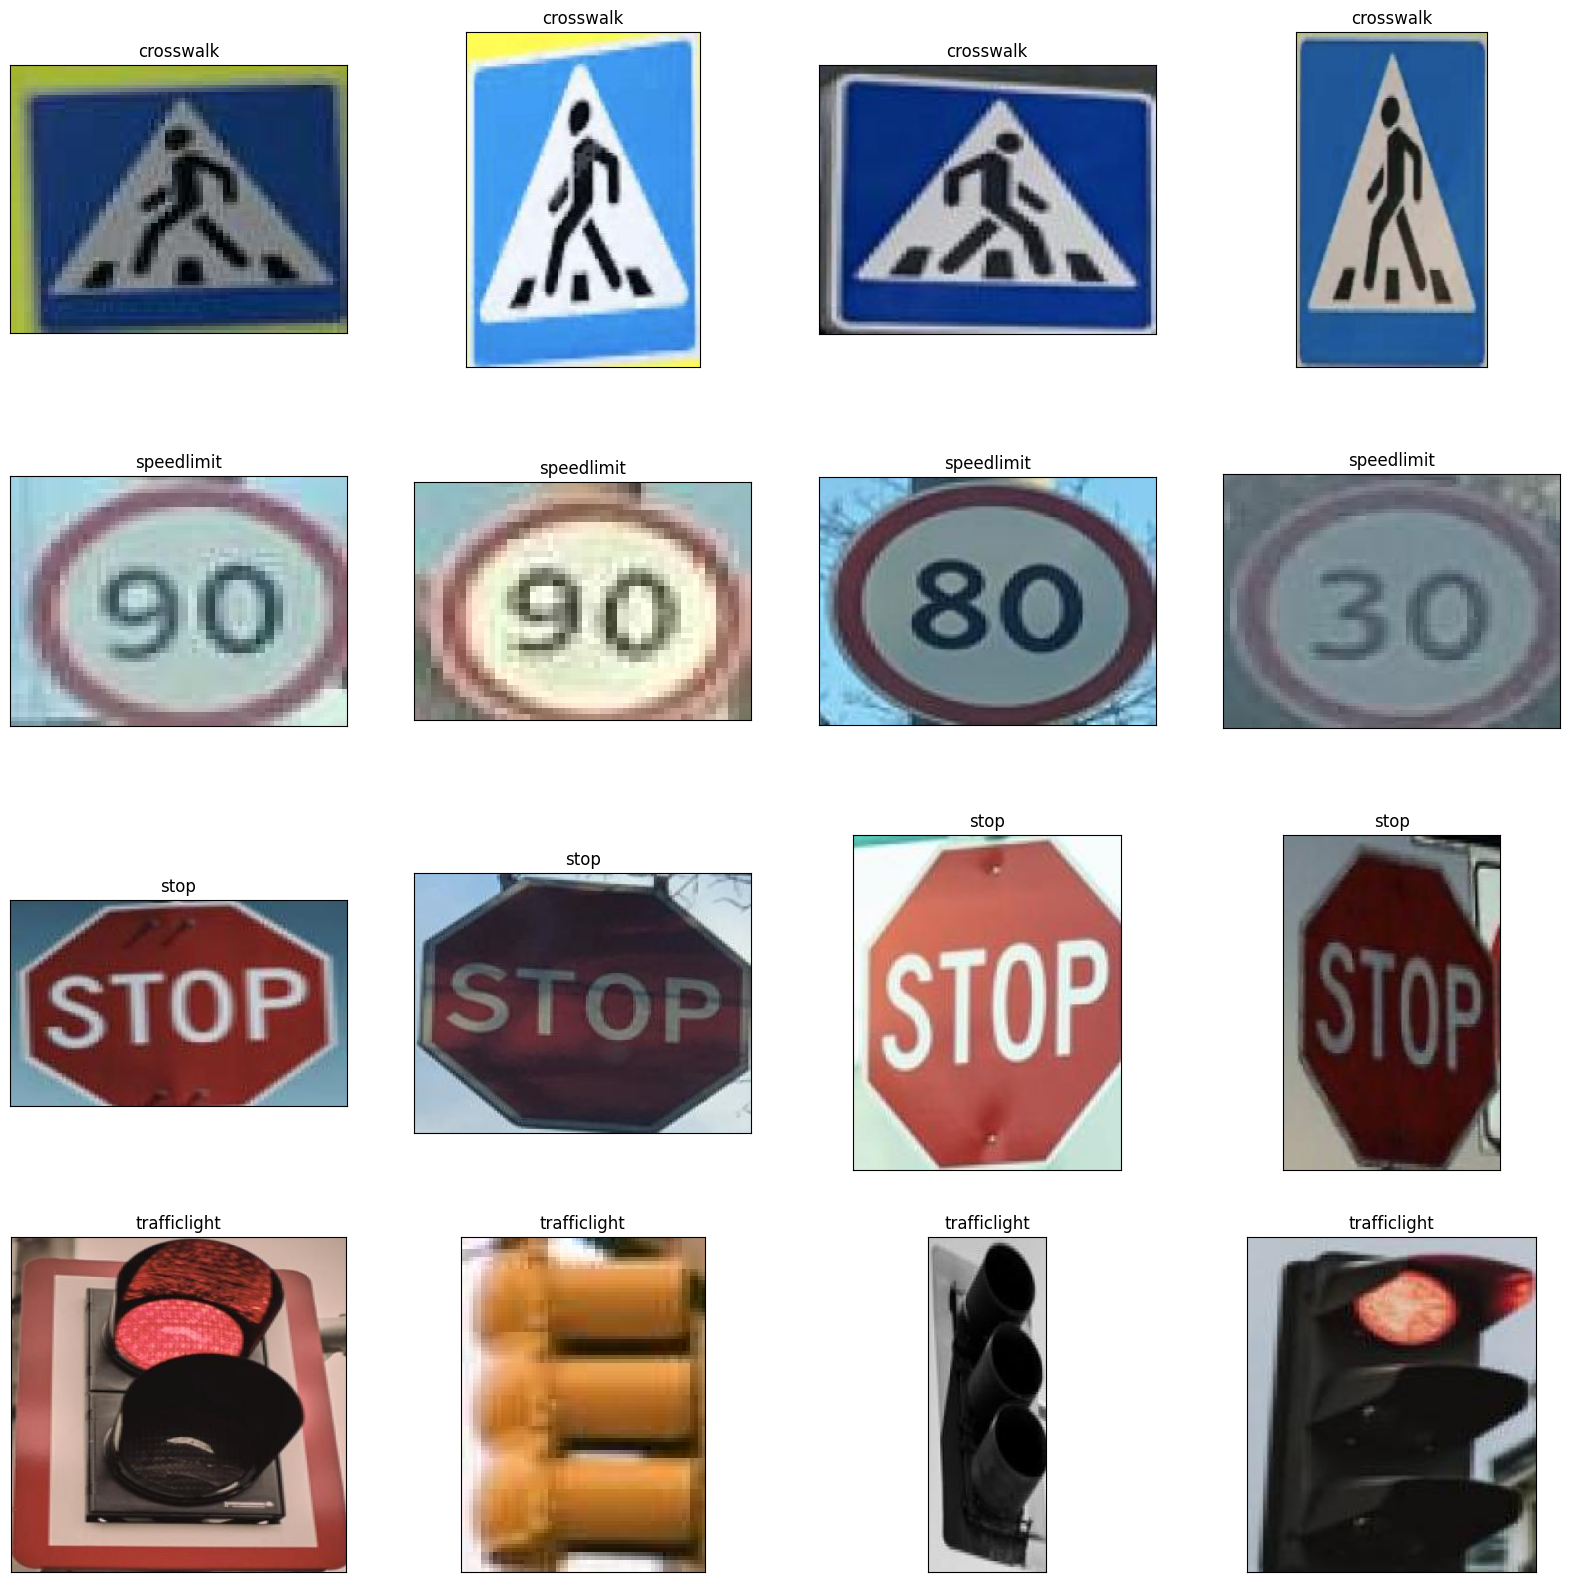

In [ ]:
tree(train_dir,print_files=False)
N=4
fig, ax = plt.subplots(4, N, figsize=(5*N, 5*4))

for i,name in enumerate(['crosswalk','speedlimit', 'stop', 'trafficlight']):
    filenames = os.listdir(os.path.join(train_dir,name))
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
plt.grid(False)
plt.show()

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'cropped_images/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs
)

model.save('mobilenet_signs.h5')

17225924/17225924 [==============================] - 2s 0us/step
Found 435 images belonging to 4 classes.
Epoch 1/30


<ipython-input-7-b8d7fe1e79b4>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


13/13 [==============================] - 6s 98ms/step - loss: 0.6804 - accuracy: 0.8561
Epoch 2/30
13/13 [==============================] - 1s 98ms/step - loss: 0.0156 - accuracy: 0.9950
Epoch 3/30
13/13 [==============================] - 1s 58ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 4/30
13/13 [==============================] - 1s 49ms/step - loss: 7.4734e-04 - accuracy: 1.0000
Epoch 5/30
13/13 [==============================] - 1s 71ms/step - loss: 3.3136e-04 - accuracy: 1.0000
Epoch 6/30
13/13 [==============================] - 1s 74ms/step - loss: 1.6522e-04 - accuracy: 1.0000
Epoch 7/30
13/13 [==============================] - 1s 62ms/step - loss: 2.9908e-04 - accuracy: 1.0000
Epoch 8/30
13/13 [==============================] - 1s 65ms/step - loss: 2.1355e-04 - accuracy: 1.0000
Epoch 9/30
13/13 [==============================] - 1s 71ms/step - loss: 1.7278e-04 - accuracy: 1.0000
Epoch 10/30
13/13 [==============================] - 2s 104ms/step - loss: 1.4004e-04 - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    class_name = classes[predicted_class]
    return class_name, confidence

# Результаты

In [ ]:
img = 'road109_png.rf.c5c72efeb8be39fa8fa4bfb1c683fe1a.jpg'
res = detect_model.predict('/content/signs/test/images/{}'.format(img), save_crop=True)
predicted_class, confidence = predict_image('/content/runs/detect/predict/crops/sign/{}'.format(img))
print(f'Predicted Class: {predicted_class}')
print(f'Confidence: {confidence}')


image 1/1 /content/signs/test/images/road109_png.rf.c5c72efeb8be39fa8fa4bfb1c683fe1a.jpg: 640x640 1 sign, 16.2ms
Speed: 7.0ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
